In [1]:
# Importing packages and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# Non-Sparse Case

# Utils functions

In [188]:
# Multiclass cross entropy loss function
def loss(X, y, params):
    N,P=X.shape
    K=params.size//(1+P)
    b=params[:K]
    W=params[K:].reshape(P,K)
    loss=0
    for i in range(N):
        y_i=y[i,:]
        index=np.argmax(y_i)
        w_i=W[:,index]
        b_i=b[index]
        loss += -1/N * np.log(np.exp(w_i.T @ X[i,:]+ b_i) / sum(np.exp(W[:,k].T @ X[i,:]+b[k]) for k in range(K)))
    return loss

In [189]:
# Another way of computing loss using the softmax function
def compute_loss(X, Y, params):
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    Y_proba = softmax(X @ W + b, axis=1)
    loss = -np.log(Y_proba[Y == 1]).mean()
    return loss

In [190]:
# Gradient of the multi class entropy loss
def gradient(X, y, params):
    K = y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    N=X.shape[0]
    grad_W=np.zeros(W.shape)
    grad_b=np.zeros(b.shape)
    for i in range(N):
        y_hat_i = np.array([np.exp(W[:,l].T @ X[i,:]+ b[l])/sum(np.exp(W[:,k].T @ X[i,:]+b[k]) for k in range(K)) for l in range(K)])
        grad_W += (1/N) * (X[i,:].reshape(P,1)) @ ((y_hat_i-y[i,:]).reshape(1,K))
        grad_b += (1/N) * (y_hat_i-y[i,:])
    grad=np.vstack((grad_b, grad_W)).ravel()
    return grad

In [191]:
# A vectorized version
def gradient_vectorized(X, y, params):
    K = y.shape[1]
    P = (params.size // K) - 1
    b = params[:K]
    W = params[K:].reshape(P, K)
    N = X.shape[0]
    y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1, keepdims=True)
    grad_W = (1/N) * np.dot(X.T, (y_hat - y))
    grad_b = (1/N) * np.sum(y_hat - y, axis=0)
    grad = np.concatenate([grad_b, grad_W.ravel()])
    return grad

In [192]:
# Function that predicts a class for each sample
def predict_class(params,X):
    _, P = X.shape
    K = params.size // (1 + P)
    b = params[:K]
    W = params[K:].reshape(P, K)
    proba_predictions = softmax(X @ W + b, axis=1)
    class_predictions = np.argmax(proba_predictions, axis=1)
    return class_predictions

# Optimizers

In [193]:
def adam_optimizer(X, y, theta, l2_penalty=0.1, learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8, epochs=100):
    N,P=X.shape
    K=y.shape[1]
    m_t=np.zeros(K+K*P)
    v_t=np.zeros(K+K*P)
    loss=[]
    t=0
    for i in range(epochs):
        t+=1
        grad=gradient_vectorized(X,y,theta)+l2_penalty*theta
        m_t=beta_1*m_t+(1-beta_1)*grad
        v_t=beta_2*v_t+(1-beta_2)*(grad**2)
        m_t_hat=m_t/(1-beta_1**t)
        v_t_hat=v_t/(1-beta_2**t)
        theta=theta-learning_rate*m_t_hat/(np.sqrt(v_t_hat)+epsilon)
        loss.append(compute_loss(X, y, theta) + l2_penalty*0.5*np.linalg.norm(theta))
    return theta, loss

In [194]:
def adagrad_optimizer(X, y, theta, l2_penalty=0.001, learning_rate=0.1, epsilon=1e-8, epochs=100):
    N,P=X.shape
    K=y.shape[1]
    gt_square=np.zeros(K+K*P)
    loss=[]
    for i in range(epochs):
        grad=gradient_vectorized(X,y,theta)+l2_penalty*theta
        gt_square+=grad**2
        theta=theta-learning_rate*grad/(np.sqrt(gt_square)+epsilon)
        loss.append(compute_loss(X, y, theta) + l2_penalty*0.5*np.linalg.norm(theta))
    return theta,loss

In [195]:
def sgd_optimizer(X, y, theta, l2_penalty=0.1, learning_rate=0.1, momentum=0.9, epochs=100):
    _,P=X.shape
    K=y.shape[1]
    velocity=np.zeros(K+K*P)
    loss=[]
    for i in range(epochs):
        grad = gradient_vectorized(X,y,theta+momentum*velocity)+l2_penalty*theta
        velocity = momentum*velocity-learning_rate*grad
        theta+= velocity
        loss.append(compute_loss(X, y, theta) + l2_penalty*0.5*np.linalg.norm(theta))
    return theta,loss

# Synthetic data

In [196]:
def generate_synthetic_data(N, P, K):
    
    np.random.seed(42)
    
    X = np.random.randn(N, P)
    
    theta = np.random.randn(P, K)
    
    logits = np.dot(X, theta)
    
    probs=np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    
    y = np.zeros((N, K))
    for i in range(N):
        y[i, np.random.choice(K, p=probs[i])] = 1
    
    return X, y 

In [197]:
N = 1000  # Number of samples
P = 10    # Number of features
K = 2     # Number of output dimensions

X_synthetic, y_synthetic = generate_synthetic_data(N, P, K)

In [239]:
# Initialization of weights
np.random.seed(42)
params=np.random.randn(K+P*K)

In [232]:
theta_adam,loss_adam = adam_optimizer(X_synthetic, y_synthetic, params, l2_penalty=0.01, learning_rate=0.1)

In [233]:
theta_adagrad,loss_adagrad = adagrad_optimizer(X_synthetic, y_synthetic, params, l2_penalty=0.01, learning_rate=0.01)

In [234]:
theta_sgd,loss_sgd = sgd_optimizer(X_synthetic, y_synthetic, params, l2_penalty=0.01, learning_rate=0.01)

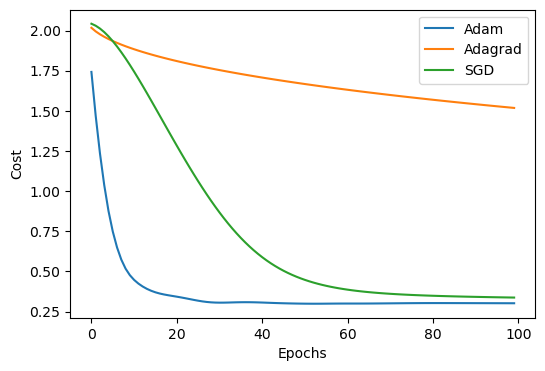

In [235]:
plt.figure(figsize=(6,4))
plt.plot(loss_adam, label='Adam')
plt.plot(loss_adagrad, label='Adagrad')
plt.plot(loss_sgd, label='SGD')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show()

We can see that Adam has the best convergence, if we assume that the global minimum is the one achieved by Adam at the end of training, we will plot the evolution of the distance between the optimal parameters to the global minimum through epochs for Adagrad and SGD Nesterov optimizers.


We will modifiy thus a bit the optimizers Adagrad and SGD Nesterov to store the distances between the optimal parameters and the global minimum.

In [236]:
theta_min = theta_adam # The global minimum

In [237]:
def adagrad_bis(X, y, theta, l2_penalty=0.001, learning_rate=0.01, epsilon=1e-8, epochs=100):
    N,P=X.shape
    K=y.shape[1]
    gt_square=np.zeros(K+K*P)
    distances=[]
    for i in range(epochs):
        grad=gradient_vectorized(X,y,theta)+l2_penalty*theta
        gt_square+=grad**2
        theta=theta-learning_rate*grad/(np.sqrt(gt_square)+epsilon)
        distances.append(np.linalg.norm(theta-theta_min))
    return distances

In [238]:
def sgd_bis(X, y, theta, l2_penalty=0.1, learning_rate=0.01, momentum=0.9, epochs=100):
    _,P=X.shape
    K=y.shape[1]
    velocity=np.zeros(K+K*P)
    distances=[]
    for i in range(epochs):
        grad = gradient_vectorized(X,y,theta+momentum*velocity)+l2_penalty*theta
        velocity = momentum*velocity-learning_rate*grad
        theta+= velocity
        distances.append(np.linalg.norm(theta-theta_min))
    return distances

In [240]:
dist_adagrad = adagrad_bis(X_synthetic, y_synthetic, params)

In [241]:
dist_sgd = sgd_bis(X_synthetic, y_synthetic, params)

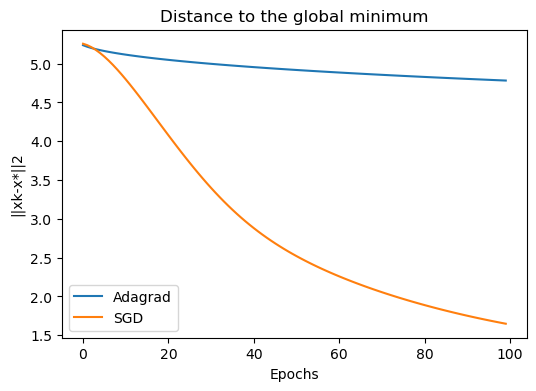

In [242]:
plt.figure(figsize=(6,4))
plt.plot(dist_adagrad, label='Adagrad')
plt.plot(dist_sgd,label='SGD')
plt.xlabel('Epochs')
plt.ylabel('||xk-x*||2')
plt.legend()
plt.title('Distance to the global minimum')
plt.show()

# Real Data

# Processing

In [164]:
# Downloading the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [165]:
# Processing X_train and X_test using min-max normalization
X_train=X_train/255
X_test=X_test/255

In [166]:
X_train_transformed=X_train.reshape(X_train.shape[0],28*28)
X_test_transformed=X_test.reshape(X_test.shape[0],28*28)

In [167]:
# One-hot encoding of the target variable y
y_train_reshaped,y_test_reshaped = y_train.reshape(-1, 1),y_test.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_one_hot,y_test_one_hot = encoder.fit_transform(y_train_reshaped),encoder.fit_transform(y_test_reshaped)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Cross validation

For each of the optimizers we perform a cross-validation to found the best hyperparameters.

In [16]:
l2_penalties = [0.001, 0.01, 0.1, 1.0]
learning_rates=[0.001, 0.01, 0.1, 1.0]
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for l2_penalty in l2_penalties:
    for learning_rate in learning_rates:
        avg_validation_accuracy = 0.0
        for train_index, val_index in kf.split(X_train_transformed):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train_one_hot[train_index], y_train_one_hot[val_index]
            P=X_train_fold.shape[1]
            K=y_train_one_hot.shape[1]
            np.random.seed(42)
            theta=np.random.randn(K+P*K)
            theta_hat = adam_optimizer(X_train_fold,y_train_fold,theta,l2_penalty,learning_rate)[0]
            classe_predictions = predict_class(theta_hat,X_val_fold)
            true_classes = np.argmax(y_val_fold, axis=1)
            accuracy = accuracy_score(true_classes, classe_predictions)
            avg_validation_accuracy+=accuracy
        avg_validation_accuracy /= k
        print(f"l2_penalty: {l2_penalty},learning_rate: {learning_rate},Avg Validation Accuracy: {avg_validation_accuracy}")

l2_penalty: 0.001,learning_rate: 0.001,Avg Validation Accuracy: 0.14886666666666667
l2_penalty: 0.001,learning_rate: 0.01,Avg Validation Accuracy: 0.7739
l2_penalty: 0.001,learning_rate: 0.1,Avg Validation Accuracy: 0.90845


C:\Users\hp\AppData\Local\Temp\ipykernel_3268\3673484487.py:8: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1, keepdims=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3268\3673484487.py:8: RuntimeWarning: invalid value encountered in divide
  y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1, keepdims=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3268\3673484487.py:8: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1, keepdims=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3268\3673484487.py:8: RuntimeWarning: invalid value encountered in divide
  y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1, keepdims=True)
C:\Users\hp\AppData\Local\Temp\ipykernel_3268\3673484487.py:8: RuntimeWarning: overflow encountered in exp
  y_hat = np.exp(np.dot(X, W) + b) / np.sum(np.exp(np.dot(X, W) + b), axis=1,

l2_penalty: 0.001,learning_rate: 1.0,Avg Validation Accuracy: 0.24866666666666667
l2_penalty: 0.01,learning_rate: 0.001,Avg Validation Accuracy: 0.12768333333333332
l2_penalty: 0.01,learning_rate: 0.01,Avg Validation Accuracy: 0.7096166666666667
l2_penalty: 0.01,learning_rate: 0.1,Avg Validation Accuracy: 0.8989666666666668
l2_penalty: 0.01,learning_rate: 1.0,Avg Validation Accuracy: 0.5805833333333333
l2_penalty: 0.1,learning_rate: 0.001,Avg Validation Accuracy: 0.08338333333333334
l2_penalty: 0.1,learning_rate: 0.01,Avg Validation Accuracy: 0.35536666666666666
l2_penalty: 0.1,learning_rate: 0.1,Avg Validation Accuracy: 0.8608166666666666
l2_penalty: 0.1,learning_rate: 1.0,Avg Validation Accuracy: 0.27853333333333335
l2_penalty: 1.0,learning_rate: 0.001,Avg Validation Accuracy: 0.07685
l2_penalty: 1.0,learning_rate: 0.01,Avg Validation Accuracy: 0.11833333333333332
l2_penalty: 1.0,learning_rate: 0.1,Avg Validation Accuracy: 0.7878499999999999
l2_penalty: 1.0,learning_rate: 1.0,Avg Val

The best hyperparameters are l2_penalty=0.001 and learning_rate=0.1.

In [18]:
l2_penalties = [0.001, 0.01, 0.1, 1.0]
learning_rates=[0.001, 0.01, 0.1, 1.0]
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for l2_penalty in l2_penalties:
    for learning_rate in learning_rates:
        avg_validation_accuracy = 0.0

        for train_index, val_index in kf.split(X_train_transformed):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train_one_hot[train_index], y_train_one_hot[val_index]
            
            P=X_train_fold.shape[1]
            K=y_train_one_hot.shape[1]
            np.random.seed(42)
            theta=np.random.randn(K+P*K)
            
            theta_hat = adagrad_optimizer(X_train_fold,y_train_fold,theta,l2_penalty,learning_rate)[0]
            classe_predictions = predict_class(theta_hat,X_val_fold)
            true_classes = np.argmax(y_val_fold, axis=1)
            accuracy = accuracy_score(true_classes, classe_predictions)
            avg_validation_accuracy+=accuracy
            
        avg_validation_accuracy /= k
        print(f"l2_penalty: {l2_penalty}, learning_rate:{learning_rate}, Avg Validation Accuracy: {avg_validation_accuracy}")

l2_penalty: 0.001, learning_rate:0.001, Avg Validation Accuracy: 0.08016666666666668
l2_penalty: 0.001, learning_rate:0.01, Avg Validation Accuracy: 0.25916666666666666
l2_penalty: 0.001, learning_rate:0.1, Avg Validation Accuracy: 0.8265166666666666
l2_penalty: 0.001, learning_rate:1.0, Avg Validation Accuracy: 0.78695
l2_penalty: 0.01, learning_rate:0.001, Avg Validation Accuracy: 0.07801666666666668
l2_penalty: 0.01, learning_rate:0.01, Avg Validation Accuracy: 0.20945
l2_penalty: 0.01, learning_rate:0.1, Avg Validation Accuracy: 0.8097166666666666
l2_penalty: 0.01, learning_rate:1.0, Avg Validation Accuracy: 0.67
l2_penalty: 0.1, learning_rate:0.001, Avg Validation Accuracy: 0.07295
l2_penalty: 0.1, learning_rate:0.01, Avg Validation Accuracy: 0.09885000000000001
l2_penalty: 0.1, learning_rate:0.1, Avg Validation Accuracy: 0.6316333333333333
l2_penalty: 0.1, learning_rate:1.0, Avg Validation Accuracy: 0.4918
l2_penalty: 1.0, learning_rate:0.001, Avg Validation Accuracy: 0.07335
l2_

In [21]:
l2_penalties = [0.001, 0.01, 0.1, 1.0]
learning_rates=[0.001, 0.01, 0.1, 1.0]
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for l2_penalty in l2_penalties:
    for learning_rate in learning_rates:
        avg_validation_accuracy = 0.0

        for train_index, val_index in kf.split(X_train_transformed):
            X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
            y_train_fold, y_val_fold = y_train_one_hot[train_index], y_train_one_hot[val_index]
            
            P=X_train_fold.shape[1]
            K=y_train_one_hot.shape[1]
            np.random.seed(42)
            theta=np.random.randn(K+P*K)
            
            theta_hat = sgd_optimizer(X_train_fold,y_train_fold,theta,l2_penalty,learning_rate)[0]
            classe_predictions = predict_class(theta_hat,X_val_fold)
            true_classes = np.argmax(y_val_fold, axis=1)
            accuracy = accuracy_score(true_classes, classe_predictions)
            avg_validation_accuracy+=accuracy
            
        avg_validation_accuracy /= k
        print(f"l2_penalty: {l2_penalty}, learning_rate:{learning_rate}, Avg Validation Accuracy: {avg_validation_accuracy}")

l2_penalty: 0.001, learning_rate:0.001, Avg Validation Accuracy: 0.08615
l2_penalty: 0.001, learning_rate:0.01, Avg Validation Accuracy: 0.3381
l2_penalty: 0.001, learning_rate:0.1, Avg Validation Accuracy: 0.80975
l2_penalty: 0.001, learning_rate:1.0, Avg Validation Accuracy: 0.9078666666666667
l2_penalty: 0.01, learning_rate:0.001, Avg Validation Accuracy: 0.08625000000000001
l2_penalty: 0.01, learning_rate:0.01, Avg Validation Accuracy: 0.35241666666666666
l2_penalty: 0.01, learning_rate:0.1, Avg Validation Accuracy: 0.8525833333333335
l2_penalty: 0.01, learning_rate:1.0, Avg Validation Accuracy: 0.8696833333333334
l2_penalty: 0.1, learning_rate:0.001, Avg Validation Accuracy: 0.08739999999999999
l2_penalty: 0.1, learning_rate:0.01, Avg Validation Accuracy: 0.5544666666666667
l2_penalty: 0.1, learning_rate:0.1, Avg Validation Accuracy: 0.8607000000000001
l2_penalty: 0.1, learning_rate:1.0, Avg Validation Accuracy: 0.3471
l2_penalty: 1.0, learning_rate:0.001, Avg Validation Accuracy:

# Results

In [23]:
# Initialization of random weights
P=X_train_transformed.shape[1]
K=y_train_one_hot.shape[1]
np.random.seed(42)
theta=np.random.randn(K+P*K)

In [15]:
theta_adam, loss_adam = adam_optimizer(X_train_transformed, y_train_one_hot, theta, l2_penalty=0.001, learning_rate=0.1)

In [24]:
theta_adagrad, loss_history_adagrad = adagrad_optimizer(X_train_transformed, y_train_one_hot, theta, l2_penalty=0.001, learning_rate=0.1)

In [27]:
theta_sgd, loss_sgd = sgd_optimizer(X_train_transformed, y_train_one_hot, theta, l2_penalty=0.001, learning_rate=1.0)

Performance of the stochastic optimmizers on the test set 

In [31]:
classe_predictions = predict_class(theta_adam,X_test_transformed)
true_classes = np.argmax(y_test_one_hot, axis=1)
accuracy_adam = accuracy_score(true_classes, classe_predictions)

In [32]:
print(accuracy_adam)

0.9161

In [33]:
classe_predictions = predict_class(theta_adagrad,X_test_transformed)
true_classes = np.argmax(y_test_one_hot, axis=1)
accuracy_adagrad = accuracy_score(true_classes, classe_predictions)

In [34]:
print(accuracy_adagrad)

0.8371

In [35]:
classe_predictions = predict_class(theta_sgd,X_test_transformed)
true_classes = np.argmax(y_test_one_hot, axis=1)
accuracy_sgd = accuracy_score(true_classes, classe_predictions)

In [36]:
print(accuracy_sgd)

0.9143

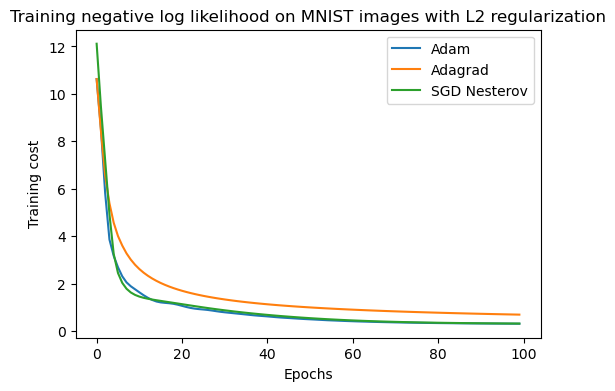

In [39]:
plt.figure(figsize=(6,4))
plt.plot(loss_adam,label='Adam')
plt.plot(loss_adagrad,label='Adagrad')
plt.plot(loss_sgd,label='SGD Nesterov')
plt.xlabel('Epochs')
plt.ylabel('Training cost')
plt.title('Training negative log likelihood on MNIST images with L2 regularization')
plt.legend()
plt.show()

# Sparse Case

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Importing packages and functions
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import math

In [4]:
# Loading the data
df=pd.read_csv('IMDB Dataset.csv')

In [5]:
# reducing the number of samples
df=df.iloc[0:40000,:]

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
39995,This was a marvelously funny comedy with a gre...,positive
39996,There is no plot. There are no central charact...,positive
39997,This show is awesome! I love all the actors! I...,positive
39998,The fact that this movie has been entitled to ...,negative


In [7]:
X=df['review']
y=df['sentiment']

In [8]:
# Checking nan-values
df.isna().sum()

review       0
sentiment    0
dtype: int64

# Processing

In [9]:
#Encoding of the target variable
y=y.replace({"positive": 1, "negative": 0})

In [10]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# List of the words from all the review
all_words = []
for review in X:
    words = word_tokenize(review.lower())  
    all_words.extend(words)

In [12]:
# Words with length less than 3 
special_words=[word for word in all_words if len(word)<=3]

In [13]:
unique_special_words = list(set(special_words))

In [14]:
# We restrict to words of lenght greater then 4 
all_words = [word for word in all_words if len(word) >= 4]

In [15]:
word_freq = Counter(all_words)

In [16]:
# Sorting the words in term of frequency
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

In [17]:
# The 10000 most frequent words among the words of all the reviews
top_10000_words = [word for word, freq in sorted_words[:10000]]

In [18]:
# We apply a dropout noise to avoid overfitting
def create_vector(review,top_words,dropout_rate):
    feature_vector = np.zeros(len(top_words))
    for word in review:
        if word in top_words:
            random_number = np.random.random()
            if random_number < dropout_rate:
                feature_vector[top_words.index(word)] = 0
            else:
                feature_vector[top_words.index(word)] += 1
    feature_vector /= len(review)

    return feature_vector

In [19]:
# Tokenization of the reviews
tokenized_X_train = X_train.apply(lambda review: word_tokenize(review.lower()))
tokenized_X_test = X_test.apply(lambda review: word_tokenize(review.lower()))

In [20]:
# Processing of X_train
dropout_rate = 0.5 # As suggested in the article
feature_vectors_train = []
for review in tokenized_X_train:
    feature_vector = create_vector(review, top_10000_words, dropout_rate)
    feature_vectors_train.append(feature_vector)

In [21]:
# Processing of X_test
dropout_rate = 0.5 
feature_vectors_test = []
for review in tokenized_X_test:
    feature_vector = create_vector(review, top_10000_words, dropout_rate)
    feature_vectors_test.append(feature_vector)

In [22]:
x_train, x_test=np.vstack(feature_vectors_train), np.vstack(feature_vectors_test)

In [23]:
y_train_,y_test_ = y_train.to_numpy(),y_test.to_numpy()

# Modeling

Adagrad

In [24]:
model_adagrad = Sequential([
    Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))])

In [25]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)

In [26]:
model_adagrad.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [27]:
history_adagrad = model_adagrad.fit(x_train, y_train_, epochs=100, validation_data=(x_test, y_test_))

Epoch 1/100
1000/1000 [==============================] - 11s 10ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 2/100
1000/1000 [==============================] - 21s 21ms/step - loss: 0.6931 - accuracy: 0.5021 - val_loss: 0.6930 - val_accuracy: 0.4999
Epoch 3/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6929 - val_accuracy: 0.4997
Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6929 - accuracy: 0.5169 - val_loss: 0.6928 - val_accuracy: 0.4999
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6928 - accuracy: 0.5195 - val_loss: 0.6927 - val_accuracy: 0.6888
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6927 - accuracy: 0.5393 - val_loss: 0.6926 - val_accuracy: 0.5004
Epoch 7/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6926 - accuracy: 0.5266 - val_loss: 0.6925 - va

In [29]:
train_loss_adagrad = history_adagrad.history['loss']
val_accuracy_adagrad = history_adagrad.history['val_accuracy']

SGD Nesterov

In [30]:
model_sgd = Sequential([
    Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))
])

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)

In [32]:
model_sgd.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history_sgd = model_sgd.fit(x_train, y_train_, epochs=100, validation_data=(x_test, y_test_))

Epoch 1/100
1000/1000 [==============================] - 10s 8ms/step - loss: 0.6948 - accuracy: 0.5029 - val_loss: 0.6942 - val_accuracy: 0.5002
Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6941 - accuracy: 0.5060 - val_loss: 0.6943 - val_accuracy: 0.4997
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6940 - accuracy: 0.5098 - val_loss: 0.6923 - val_accuracy: 0.5009
Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6939 - accuracy: 0.5020 - val_loss: 0.6920 - val_accuracy: 0.6976
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6937 - accuracy: 0.5089 - val_loss: 0.6921 - val_accuracy: 0.5002
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6932 - accuracy: 0.5163 - val_loss: 0.6952 - val_accuracy: 0.4997
Epoch 7/100
1000/1000 [==============================] - 6s 5ms/step - loss: 0.6932 - accuracy: 0.5150 - val_loss: 0.6926 - val_a

In [34]:
train_loss_sgd = history_sgd.history['loss']
val_accuracy_sgd = history_sgd.history['val_accuracy']

RMSProp

In [35]:
model_rmsprop = Sequential([
    Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))
])

In [36]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.1)

In [37]:
model_rmsprop.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [38]:
history_rmsprop = model_rmsprop.fit(x_train, y_train_, epochs=100, validation_data=(x_test, y_test_))

Epoch 1/100
1000/1000 [==============================] - 11s 10ms/step - loss: 0.6641 - accuracy: 0.6283 - val_loss: 0.6345 - val_accuracy: 0.7460
Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6176 - accuracy: 0.7212 - val_loss: 0.5995 - val_accuracy: 0.7526
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5872 - accuracy: 0.7429 - val_loss: 0.5748 - val_accuracy: 0.7614
Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5655 - accuracy: 0.7581 - val_loss: 0.5568 - val_accuracy: 0.7676
Epoch 5/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.5486 - accuracy: 0.7663 - val_loss: 0.5430 - val_accuracy: 0.7682
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5353 - accuracy: 0.7731 - val_loss: 0.5309 - val_accuracy: 0.7765
Epoch 7/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.5236 - accuracy: 0.7793 - val_loss: 0.5212 - val_

In [39]:
train_loss_rmsprop = history_rmsprop.history['loss']
val_accuracy_rmsprop = history_rmsprop.history['val_accuracy']

Adam

In [40]:
def sqrt_decay(epoch, lr):
    return lr / math.sqrt(epoch + 1)

In [41]:
model_adam = Sequential([
    Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))
])

In [42]:
beta_1 = 1e-5

In [43]:
optimizer = Adam(learning_rate=0.1,beta_1=beta_1)

In [44]:
model_adam.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [45]:
lr_scheduler = LearningRateScheduler(sqrt_decay)

In [46]:
history_adam = model_adam.fit(x_train, y_train_, epochs=100, validation_data=(x_test, y_test_), callbacks=[lr_scheduler])

Epoch 1/100
1000/1000 [==============================] - 13s 11ms/step - loss: 0.6055 - accuracy: 0.7390 - val_loss: 0.5389 - val_accuracy: 0.8087 - lr: 0.1000
Epoch 2/100
1000/1000 [==============================] - 7s 7ms/step - loss: 0.5026 - accuracy: 0.8241 - val_loss: 0.4905 - val_accuracy: 0.8083 - lr: 0.0707
Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4624 - accuracy: 0.8390 - val_loss: 0.4700 - val_accuracy: 0.8161 - lr: 0.0408
Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4445 - accuracy: 0.8460 - val_loss: 0.4609 - val_accuracy: 0.8216 - lr: 0.0204
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4366 - accuracy: 0.8479 - val_loss: 0.4574 - val_accuracy: 0.8226 - lr: 0.0091
Epoch 6/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.4332 - accuracy: 0.8495 - val_loss: 0.4561 - val_accuracy: 0.8226 - lr: 0.0037
Epoch 7/100
1000/1000 [===========================

In [47]:
train_loss_adam = history_adam.history['loss']
val_accuracy_adam = history_adam.history['val_accuracy']

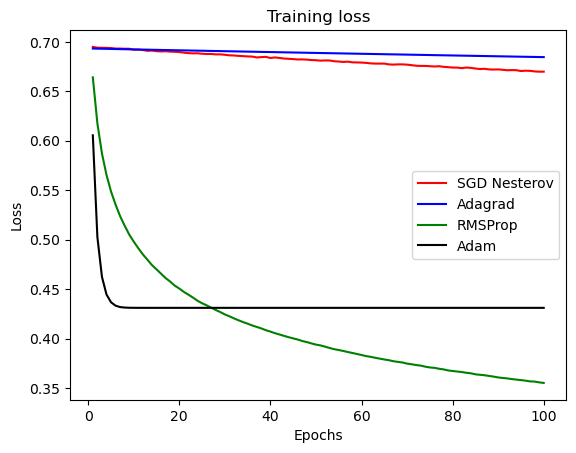

In [48]:
epochs = range(1, len(train_loss_sgd) + 1)
plt.plot(epochs, train_loss_sgd, 'r', label='SGD Nesterov')
plt.plot(epochs, train_loss_adagrad, 'b', label='Adagrad')
plt.plot(epochs, train_loss_rmsprop, 'g', label='RMSProp')
plt.plot(epochs, train_loss_adam, 'black', label='Adam')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

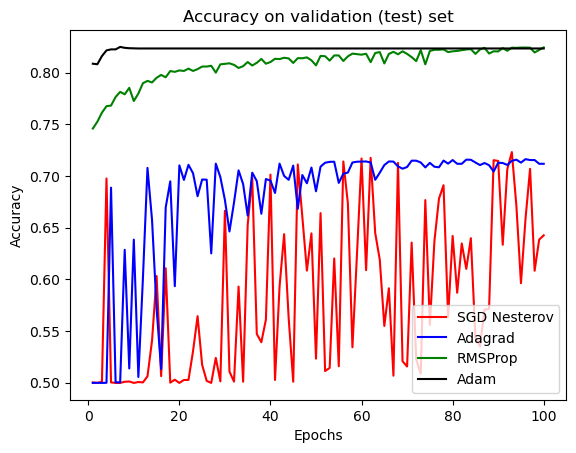

In [49]:
epochs = range(1, len(train_loss_sgd) + 1)
plt.plot(epochs, val_accuracy_sgd, 'r', label='SGD Nesterov')
plt.plot(epochs, val_accuracy_adagrad, 'b', label='Adagrad')
plt.plot(epochs, val_accuracy_rmsprop, 'g', label='RMSProp')
plt.plot(epochs, val_accuracy_adam, 'black', label='Adam')
plt.title('Accuracy on validation (test) set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Influence of the learning rate on accuracy of SGD Nesterov

In [24]:
grid_rate=[0.005, 0.01, 0.05, 0.1, 1]
accuracy=[]
for x in grid_rate:
    model_sgd = Sequential([
    Dense(1, activation='sigmoid', input_shape=(x_train.shape[1],))])
    optimizer = tf.keras.optimizers.SGD(learning_rate=x, momentum=0.9, nesterov=True)
    model_sgd.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    history_sgd = model_sgd.fit(x_train, y_train_, epochs=40, validation_data=(x_test, y_test_))
    accuracy.append(history_sgd.history['val_accuracy'])

Epoch 1/40
1000/1000 [==============================] - 37s 35ms/step - loss: 0.6932 - accuracy: 0.4973 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 2/40
1000/1000 [==============================] - 5s 4ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 3/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6933 - val_accuracy: 0.5002
Epoch 4/40
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6931 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 6/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6930 - val_accuracy: 0.5004
Epoch 7/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6931 - val_accurac

1000/1000 [==============================] - 6s 6ms/step - loss: 0.6930 - accuracy: 0.5084 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 18/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6929 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5002
Epoch 19/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6928 - accuracy: 0.5105 - val_loss: 0.6929 - val_accuracy: 0.4997
Epoch 20/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6928 - accuracy: 0.5081 - val_loss: 0.6926 - val_accuracy: 0.5185
Epoch 21/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6928 - accuracy: 0.5125 - val_loss: 0.6926 - val_accuracy: 0.5020
Epoch 22/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6927 - accuracy: 0.5128 - val_loss: 0.6927 - val_accuracy: 0.4997
Epoch 23/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6927 - accuracy: 0.5187 - val_loss: 0.6925 - val_accuracy: 0.50

1000/1000 [==============================] - 6s 6ms/step - loss: 0.6890 - accuracy: 0.5409 - val_loss: 0.6905 - val_accuracy: 0.5005
Epoch 34/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6895 - accuracy: 0.5433 - val_loss: 0.6900 - val_accuracy: 0.5008
Epoch 35/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6892 - accuracy: 0.5435 - val_loss: 0.6889 - val_accuracy: 0.5117
Epoch 36/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6891 - accuracy: 0.5445 - val_loss: 0.6893 - val_accuracy: 0.5016
Epoch 37/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6888 - accuracy: 0.5445 - val_loss: 0.6882 - val_accuracy: 0.6955
Epoch 38/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6890 - accuracy: 0.5503 - val_loss: 0.6881 - val_accuracy: 0.6308
Epoch 39/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6887 - accuracy: 0.5441 - val_loss: 0.6882 - val_accuracy: 0.53

Epoch 10/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6783 - accuracy: 0.5722 - val_loss: 0.6809 - val_accuracy: 0.5070
Epoch 11/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6761 - accuracy: 0.5717 - val_loss: 0.6672 - val_accuracy: 0.6616
Epoch 12/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6750 - accuracy: 0.5794 - val_loss: 0.6648 - val_accuracy: 0.7166
Epoch 13/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6725 - accuracy: 0.5819 - val_loss: 0.6952 - val_accuracy: 0.5031
Epoch 14/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6692 - accuracy: 0.5950 - val_loss: 0.6642 - val_accuracy: 0.5865
Epoch 15/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6688 - accuracy: 0.5903 - val_loss: 0.6782 - val_accuracy: 0.5141
Epoch 16/40
1000/1000 [==============================] - 6s 6ms/step - loss: 0.6663 - accuracy: 0.5948 - val_loss: 0.6577 - val_ac

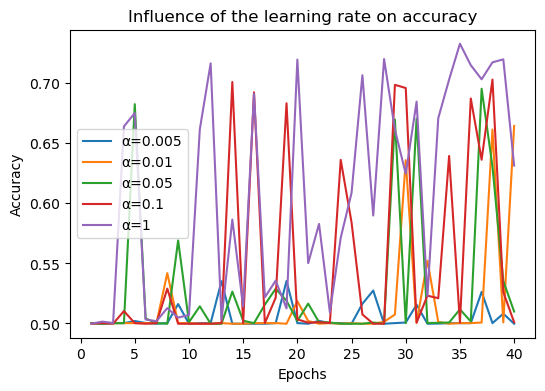

In [25]:
plt.figure(figsize=(6,4))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
epochs = range(1, len(accuracy[0]) + 1)
for i in range(len(accuracy)):
    plt.plot(epochs,accuracy[i],label=f'α={grid_rate[i]}')
plt.legend()
plt.title('Influence of the learning rate on accuracy')
plt.show()